# Implementing an explicit Runge-Kutta method with extensisq

An explicit Runge-Kutta method can be directly implemented from a Butcher tableau. This can be done with RungeKutta class of scipy, or that of extensisq in a similar way. The class in extensisq has a few extras.

A butcher tableau contains the following arrays (wikipedia):

![tableau_general](https://wikimedia.org/api/rest_v1/media/math/render/svg/27190eeffeee1a49601d6f687ef0c1fdd36ac699)

Where $c$ are the time fraction coefficients or nodes, $b$ are the output coefficients or weights and $a$ is the coefficient matrix. Embedded methods contain two sets of weights $b$: the solution and a secondary solution that is used for error estimation with adaptive time stepping. In explicit methods, the diagonal $a_{ii}$ and everything above it are 0.

In this notebook we will implement the Heun/Euler method. It is the simplest [(wikipedia)](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Heun%E2%80%93Euler) embedded explicit Runge Kutta method as has Butcher Tableau:

![tableau_HE2](https://wikimedia.org/api/rest_v1/media/math/render/svg/6af1ef9c788c64a1b2cab69bc2fcf332e562d71c)

The $a$ part of the tableau has 2 rows, which means that the method has two effective stages. The primary method is typically defined by the first line with $b$-coefficients, and the secondary method by the second line. In this case the orders are 2 and 1 for the primary and secondary methods respectively. This is enough information to implement the method.

In [11]:
import numpy as np
from extensisq.common import RungeKutta

class Heun(RungeKutta):
    n_stages = 2
    order = 2
    order_secondary = 1
    C = np.array([0, 1.])
    A = np.array([[0, 0], [1., 0]])
    B = np.array([1/2, 1/2])
    E = np.array([1., 0, 0])
    E[:-1] -= B

That's all!

Capital letters are used for the arrays of coefficients. The array $E$ contains error coefficients. It is the difference between the secondary and primary $B$ coefficients. Sometimes it is unclear if coefficents are for output or for error. Then it helps to know that output coefficients sum up to 1, while error coefficients sum up to 0.

Notice that the length of the $E$ array is one more than the length of the $B$ array. This is to allow for *FSAL* methods (first same as last). These methods do the derivative function evaluation at the output point of the primary method before the error estimation. This gives some extra information for the error estimate. This evaluation in not counted in `n_stages`, because it needs to be done anyway for the first stage of the next step (assuming that the current step is successful). The Heun/Euler method is not an FSAL method and therefore the last coefficient of E is 0.

## Test the method
A linear forced mass/spring/damper system is used to test the method and a reference solution is created with the `CFMR7osc` method.

In [12]:
from scipy.integrate import solve_ivp
from extensisq import CFMR7osc

def mass_spring_damper(t, y): return [y[1], 1.-(y[0] + y[1]/2)]
t_span = (0, 16)
y0 = [0, -1]

ref = solve_ivp(mass_spring_damper, t_span, y0, rtol=1e-6,
                method=CFMR7osc, dense_output=True)
print('nr of successful steps:', ref.t.size)
print('nr of function evaluations:', ref.nfev)

nr of successful steps: 24
nr of function evaluations: 212


Now we use our new Heun/Euler method in a similar way. A low order method is mainly used at high tolerance, so we set it higher than default. (Using a fixed small time step could be another use case.)  

In [13]:
sol = solve_ivp(mass_spring_damper, t_span, y0, atol=0.05,
                method=Heun, dense_output=True)
print('nr of successful steps:', sol.t.size)
print('nr of function evaluations:', sol.nfev)
print('error at the end point', sol.y[:,-1] - ref.sol(t_span[-1]))

nr of successful steps: 29
nr of function evaluations: 61
error at the end point [ 0.0127291  -0.05608002]


A small number of steps and evaluations is done. The ratio is almost equal to n_steps (2), as expected. Determining the initial step size takes a few evaluations, and rejected steps could take some too.

Notice that we have used dense output. A cubic hermite interpolant is included by default, allowing for dense output and events to be used. This interpolant is good enough for low order methods, but for high order methods you probably want to implement a custom interpolant. This can be done with the coefficient array $P$. The extensisq code of `Ts5` and the [paper of Tsitouras](https://doi.org/10.1016/j.camwa.2011.06.002) are a recommended starting point to figure out how this works. (Expand the polynomials)

Finally, let's compare the solutions we have generated in a plot.

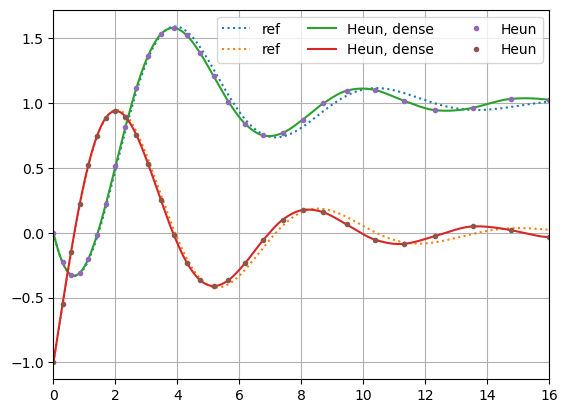

In [14]:
import matplotlib.pyplot as plt

t = np.linspace(*t_span, 300)
plt.plot(t, ref.sol(t).T, ':', label='ref')
plt.plot(t, sol.sol(t).T, label='Heun, dense')
plt.plot(sol.t, sol.y.T, '.', label='Heun')
plt.grid()
plt.legend(ncol=3)
plt.xlim(*t_span)
plt.show()

The solution calculated with the Heun/Euler method clearly resembles the reference solution, but errors build up over time. This is what we can expect for a high tolerance, of course. The dense output smoothly interpolates the solution.

## Improvements
An improved secondary method that uses the FSAL mechnism is described in [this paper](https://doi.org/10.1016/j.mcm.2005.01.010). We can also add stiffness detection by specifying the stability region. (The mentioned paper uses a different way to detect stiffness.) Heun's method has the same stability domain as every second order two stage explicit RK method. It crosses the real axis at -2, so `strad` = 2. Also, it doesn't cover much near the imaginary axis, so `tanang`, the tangent of the valid angle is small, say 2. This is implemented as:

In [15]:
class HeunImproved(Heun):
    E = np.array([1., -1/6, 1/6])   # FSAL embedded method
    E[:-1] -= Heun.B
    stbrad = 2.  # radius of the arc
    tanang = 2.  # tan(valid angle < pi/2)

# test:
sol = solve_ivp(mass_spring_damper, t_span, y0, atol=0.05,
                method=HeunImproved, dense_output=True)
print('nr of successful steps:', sol.t.size)
print('nr of function evaluations:', sol.nfev)
print('error at the end point', sol.y[:,-1] - ref.sol(t_span[-1]))


nr of successful steps: 30
nr of function evaluations: 63
error at the end point [ 0.01486142 -0.04605903]


The improved method should have a better error estimate, but the difference is small in this problem. Only one extra step is taken and the error at the end point is slightly smaller.

To test if the stiffness detection works, I define two modified problems. One without a damper, and one that is overdamped. The limit of when to check for stiffness is reduced from 5000 to 100 evaluations for this demonstration; the `nfev_stiff_detect` option isn't needed otherwise.

In [16]:
# this should not give a stiffness warning
sol = solve_ivp(mass_spring_damper, t_span, y0,
                method=HeunImproved, nfev_stiff_detect=100)
print(sol.nfev)

# this should give a stiffness warning about complex roots
def mass_spring(t, y): return [y[1], 1. - y[0]]
sol = solve_ivp(mass_spring, t_span, y0,
                method=HeunImproved, nfev_stiff_detect=100)
print(sol.nfev)

# this should give a stiffness warning about a real root
def mass_spring_DAMPER(t, y): return [y[1], 1. - (y[0] + y[1]*100)]
sol = solve_ivp(mass_spring_DAMPER, t_span, y0,
                method=HeunImproved, nfev_stiff_detect=100)
print(sol.nfev)

# warnings could appear after the number of iterations

1076
1261
1997


C:\Users\Gebruiker\Documents\GitHub\extensisq\extensisq\common.py:474: UserWarning: Your problem has a complex pair of dominant roots near the imaginary axis.  There are many recently failed steps.  You should probably change to a code intended for oscillatory problems.
  warn('Your problem has a complex pair of dominant '
C:\Users\Gebruiker\Documents\GitHub\extensisq\extensisq\common.py:495: UserWarning: Your problem has a real dominant root and is diagnosed as stiff.  You should probably change to a code intended for stiff problems.
  warn('Your problem has a real dominant root '


The expected warnings are given.

I hope this gives an idea of how to implement an explicit Runge Kutta method in extensisq. Have fun experimenting with it. 